In [0]:
%matplotlib inline

import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt

Flappy Bird time! This example has been adapted from Moritz Hardt's CS227 notes at UC Berkeley.

The equation of motion for Flappy is F = ma = mg - kv.
or, dv/dt = g - k/m v .

We need to learn a policy of accelerating upwards so that Flappy doesn't crash into the ground.

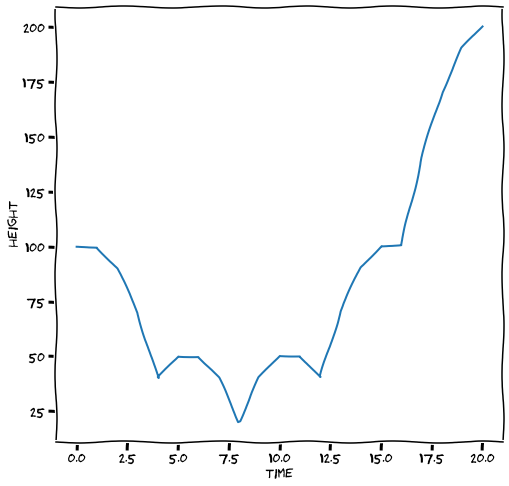

In [2]:
def flappy_bird(state, action):
    v, h = state
    g = 10. # acceleration due to gravity
    k = 0.01 # drag coefficient
    m = 10. # mass
    return (v + g - (k/m)*v - action, h - v)

def unroll(system, inits, policy, num_steps):
    """roll out the dynamical system."""
    states = [inits[0]]
    actions = [inits[1]]
    for _ in range(num_steps):
        action = policy(states, actions)
        actions.append(action)
        states.append(system(states[-1], action))
    return states, actions

def test_policy(states, actions):
    """Accelerate upwards every 4 steps."""
    v, h = states[-1]
    if divmod(len(states), 4)[1] == 0:
        return 50
    else:
        return 0.

flappy_inits = [(0, 100.), 0]
states, actions = unroll(flappy_bird, flappy_inits, test_policy, num_steps=20)
heights = [h for (v, h) in states]

plt.xkcd(); 
fig = plt.figure(figsize=(8,8))
plt.ylabel('height'); 
plt.xlabel('time');
plt.plot(range(len(heights)), heights);

Note that this policy is good (Flappy never crashes) but we had to guess it. Try playing around with other policies.

Policy gradients in RL is similar to gradient-free optimization (or random search). Let's implement that first.

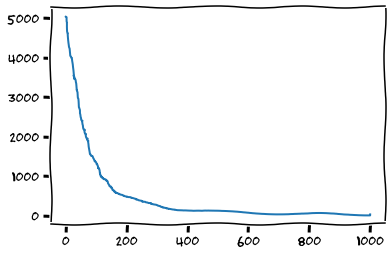

In [3]:
np.random.seed(1)
def ts(f,a,b,tol=1e-3):
  
  while True:
    if abs(b-a) < tol:
      return (a+b)/2

    c = a + (b-a)/3
    d = b - (b-a)/3
    if f(c) < f(d):
      b = d
    else:
      a = c

def random_search(oracle, init, num_steps, line_search=ts):
    iterates = [init]
    for _ in range(num_steps):
        d = np.random.normal(0, 100, init.shape)
        d /= np.linalg.norm(d)
        x = iterates[-1]
        eta = line_search(lambda step: oracle(x + step * d), -1, 1)
        iterates.append(x + eta * d)
    return iterates 

A = np.random.normal(0, 1, (100, 100))
b = np.random.normal(0, 1, (100,))
def least_squares(x):
    return 0.5*np.linalg.norm(A.dot(x)-b)**2

xs = random_search(least_squares, b, 1000, ts)
plt.plot([least_squares(x) for x in xs])
plt.show()

OK, now let's use RL to *learn* a policy of (upward) accelerations for Flappy. This, as we discussed in class, is going to be done using gradient-free optimization. We would like to minimize the number of upward "boosts" needed without ever crashing to the ground.

In RL, we need to set up:
* a *reward*
* a parametric *policy*
* a *simulator* that returns a reward for a rollout using a given policy
* an *objective function* that captures the effect of the policy on the reward for a given trajectory
* and the optimization algorithm that is used.

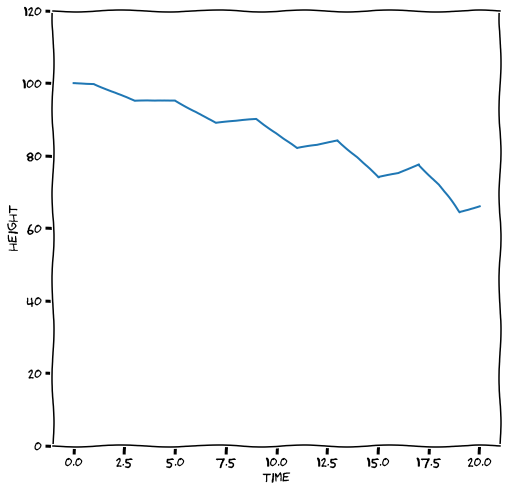

In [4]:
def flappy_reward(states, actions):
  reward = 0
  for state, action in zip(states, actions):
    _, height = state
    if height < 0:
      reward += 10*height # if flappy crashes, give big negative reward
    reward -= action #if accelerate, we burn fuel; give small negative reward
  return reward

def flappy_policy(param,states,actions):
  # let's ignore previous actions and focus on prev 2 states
  if len(states) == 1:
    states = states + states
  return np.dot(param,np.reshape(np.array(states[-2:]),(4,)))

def flappy_simulator(param,num_steps):
  policy = lambda states, actions: flappy_policy(param,states,actions)
  states, actions = unroll(flappy_bird, flappy_inits, policy, num_steps)
  return flappy_reward(states,actions)

def objective(param,horizon=20):
  return -1*flappy_simulator(param,horizon)

# we use random search to optimize the policy
optimal_param = random_search(objective,np.zeros(4),num_steps=20,line_search=ts)
rl_policy = lambda states, actions: flappy_policy(optimal_param[-1],states,actions)
states, actions = unroll(flappy_bird,flappy_inits,rl_policy,20)

heights = [h for (v, h) in states]
plt.xkcd(); 
fig = plt.figure(figsize=(8,8))
plt.ylabel('height'); 
plt.xlabel('time');
plt.ylim(0,120.)
plt.plot(range(len(heights)), heights);

Cool! Looks like we learned a reasonably successful policy.

Unfortunately since we have used sample rollouts instead of calculating the actual expectation over the rewards, our final model is rather unstable. Try running with different random seeds and see widely the policy fluctuates.

Also, we have used a fixed number of time steps (20) for each sample rollout. This has a dramatic effect on the learned policy as well. 